In [1]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt 
os.chdir('C:\\Users\\Sanata\\Dropbox\\01AA_Insight Projects\\Restaurants')
pd.options.display.max_rows = 50

In [17]:
final = pd.read_pickle('restaurant_final_data_2519')

In [18]:
##ADD 500 buffer ### 
buffers = pd.read_csv('restaurants_buffer.csv', usecols = [1, 2, 3, 4 ])
final = final.merge(buffers, on = ['bus_name', 'Building_ID_No'], how='left')
final['subway500'] = None 
final.loc[final.n_subway_ent>0, 'subway500'] = 1
final.loc[final.n_subway_ent==0, 'subway500'] = 0

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
##Preprocessing 
dat = final[(final.is_chain==0)]

#get vars 
Xvar = [#restaurant-level
          'on_avenue', 
          'ztype__R', 
          'n_restaurants_500', 
          'subway500',
          #block-level restaurant features 
          'nrest_by_block', 
          'chains_by_block', 
          'block_duration',  
          'n_sales_250k', 
          'n_sales_500k', 
          'n_sales_1m',
          #block-level census features 
          'med_block_income',
          'total_block_pop', 
          'block_pop_dens', 
          'pct_white',  
          'pct_hisp', 
          'pct_black', 
          'pct_25_34', 
          'BRONX', 'BROOKLYN', 'STATEN ISLAND', 'QUEENS']

yvar = 'n_years_open'


In [20]:
sub = dat[Xvar + [yvar]].dropna()
df_scaled = pd.DataFrame( preprocessing.scale(sub), columns = sub.columns)
mod_frame = df_scaled[Xvar]
y = sub[yvar]

C:\Users\Sanata\Anaconda3\envs\insight\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  


In [23]:
#split the data 
X_train, X_test, y_train, y_test = train_test_split(mod_frame, y, test_size=0.25, random_state=0)


Linear Regression

In [24]:
#fit model 
lr = LinearRegression().fit(X_train, y_train)
#get coefficients 
lr_coefs = pd.Series(lr.coef_, index = X_train.columns).sort_values()
lr_coefs

chains_by_block     -0.582256
n_restaurants_500   -0.069044
total_block_pop     -0.016719
pct_25_34           -0.007572
QUEENS              -0.007532
med_block_income    -0.006344
n_sales_500k        -0.003198
on_avenue           -0.002569
pct_hisp            -0.002252
block_pop_dens      -0.000208
pct_black            0.001783
BROOKLYN             0.004309
STATEN ISLAND        0.008049
BRONX                0.009469
n_sales_250k         0.009541
subway500            0.020765
pct_white            0.022549
ztype__R             0.045176
n_sales_1m           0.063044
nrest_by_block       0.469032
block_duration       0.515225
dtype: float64

In [25]:
#get accuracy 
train_acc = lr.score(X_train, y_train)
test_acc = lr.score(X_test, y_test)
print("Training set score (R-squared): {:.2f}".format(train_acc))
print("Test set score (R-squared): {:.2f}".format(test_acc))


Training set score (R-squared): 0.12
Test set score (R-squared): 0.09


In [26]:
#get y-hats 
y_pred_lr = lr.predict(X_test) #mean 2.74 years 

#get model error 
rmse_lr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr))
print(rmse_lr) 

1.3296340252566308


In [29]:
keep = ['chains_by_block', 'n_restaurants_500', 'pct_25_34',
        'pct_white',  'ztype__R','n_sales_1m', 'nrest_by_block', 'block_duration']
labels = ['N chains', 'N Rest (500 ft)', 'Age 25-34', 'Prop White', 'Residential Zone',
          '$1M Sales', 'N restaurants', 'Block rates']

Text(0.5, 0, 'Coefficient magnitude')

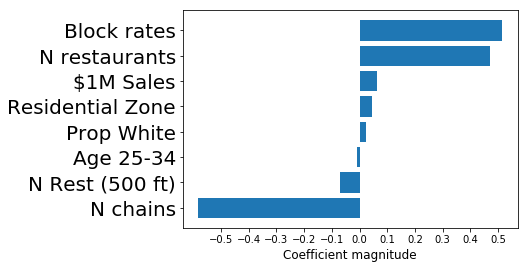

In [30]:
y_pos = np.arange(lr_coefs[keep].shape[0])
fig = plt.figure() 
ax = fig.add_subplot(111)
ax.barh(np.arange(lr_coefs[keep].shape[0]),lr_coefs[keep].T)
ax.set_yticks(y_pos)
ax.set_xticks([-.5, -.4, -.3, -.2, -.1, 0, .1, .2, .3, 0.4, 0.5])
ax.set_yticklabels(labels, fontsize=20)
ax.set_xlabel("Coefficient magnitude", fontsize=12)

Random Forest 

In [31]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=4, random_state=0,
                              n_estimators=100)
#fit model 
regr.fit(X_train, y_train)

#get feature importances 
feat_imp = pd.Series(regr.feature_importances_, index = X_train.columns).sort_values(ascending=False)
feat_imp


block_duration       0.803423
chains_by_block      0.145310
nrest_by_block       0.037799
pct_white            0.002658
n_sales_250k         0.002258
pct_black            0.002105
med_block_income     0.001105
n_restaurants_500    0.000947
total_block_pop      0.000923
block_pop_dens       0.000909
pct_hisp             0.000885
n_sales_1m           0.000685
pct_25_34            0.000581
n_sales_500k         0.000337
ztype__R             0.000059
on_avenue            0.000015
STATEN ISLAND        0.000000
subway500            0.000000
BRONX                0.000000
BROOKLYN             0.000000
QUEENS               0.000000
dtype: float64

In [32]:
#get R2
R_2 = regr.score(X_test, y_test)
print(R_2)

0.1642253570218194


In [33]:
#get RMSE 
y_pred_rf = pd.Series(regr.predict(X_test), index=y_test.index)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))) 


1.2741397161525916


Text(0.5, 1.0, 'Predicted Duration Random Forest')

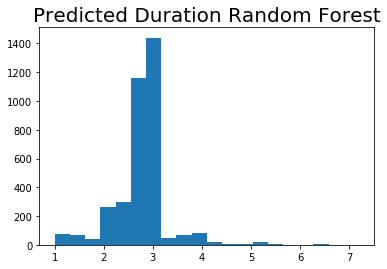

In [34]:
plt.hist(y_pred_rf, bins=20)
plt.title('Predicted Duration Random Forest', fontsize=20)


## By Borough

In [35]:
boro = ['MANHATTAN', 'BROOKLYN', 'BRONX', 'QUEENS', 'STATEN ISLAND']
coefs = []
rmse = []
accuracy = []

In [36]:
for i in range(len(boro)):
    
    #pre-process
    dat = final[(final.is_chain==0)
                & (final.Borough==boro[i])]
    
    yvar = 'n_years_open'
    sub = dat[Xvar + [yvar]].dropna()
    df_scaled = pd.DataFrame( preprocessing.scale(sub), columns = sub.columns)
    mod_frame = df_scaled[Xvar]
    y = sub[yvar]
    #split the data 
    X_train, X_test, y_train, y_test = train_test_split(mod_frame, y, test_size=0.25, random_state=0)
    
    #fit model 
    lr = LinearRegression().fit(X_train, y_train)
    
    #get coefficients 
    lr_coefs = pd.Series(lr.coef_, index = X_train.columns).sort_values()
    coefs.append(lr_coefs)
    
    #get accuracy 
    test_acc = lr.score(X_test, y_test)
    accuracy.append(test_acc)
    
    #get model error 
    y_pred_lr = lr.predict(X_test)    
    rmse_lr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr))
    rmse.append(rmse_lr)

C:\Users\Sanata\Anaconda3\envs\insight\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':
C:\Users\Sanata\Anaconda3\envs\insight\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':
C:\Users\Sanata\Anaconda3\envs\insight\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':
C:\Users\Sanata\Anaconda3\envs\insight\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':
C:\Users\Sanata\Anaconda3\envs\insight\lib\site-packages\ipykernel_launcher.

In [37]:
rmse_srs = pd.Series(rmse, index=boro)

In [38]:
rmse_srs

MANHATTAN        1.392212
BROOKLYN         1.314475
BRONX            1.237334
QUEENS           1.255154
STATEN ISLAND    1.348598
dtype: float64

The model did best in Queens, Bronx, and Brooklyn, worst in Manhattan, Staten Island. 

In [39]:
accurac_srs = pd.Series(accuracy, index=boro)
accurac_srs

MANHATTAN        0.064017
BROOKLYN         0.164644
BRONX            0.159224
QUEENS           0.149818
STATEN ISLAND    0.159782
dtype: float64